# Imports

In [2]:
import pytorch_lightning as pl
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import WandbLogger
import skimage.io
from skimage.color import gray2rgb
import os
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torch import nn
from torch.utils.data import random_split, DataLoader, Dataset

from torchvision import transforms
import wandb

Set random state for reproducibility

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# Pytorch Dataset and Lightning Datamodule Implementation

In [4]:
class GoogleDataset(Dataset):
    """Google Image Dataset."""

    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir,
                self.df.iloc[idx].label,
                self.df.iloc[idx].image_name)
                
        image = skimage.io.imread(img_path)
        if len(image.shape) < 3:
            image = gray2rgb(image)
        
        image = image.copy()
        if self.transform is not None:
            image = self.transform(image)

        return image

In [5]:
class GoogleDataModule(pl.LightningDataModule):
    def __init__(self, csv_path, batch_size, image_dir):
        super().__init__()
        self.csv_path = csv_path
        self.image_dir = image_dir
        self.batch_size = batch_size

        self.transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            # transforms.Resize((224,224), antialias=True)
        ])
        
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            # transforms.Resize((224,224), antialias=True)
        ])
    
    def setup(self, stage=None):
        google_full = GoogleDataset(self.csv_path, self.image_dir, transform=self.transform_train)
        train_size = int(len(google_full) * 0.9)
        val_size = int((len(google_full) - train_size)*0.01)
        trash_size = len(google_full) - train_size -val_size
        self.google_train, self.google_val, _ = random_split(google_full, [train_size, val_size, trash_size])
    
    def train_dataloader(self):
        return DataLoader(self.google_train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.google_val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.google_val, batch_size=self.batch_size, num_workers=12)

# Image Logging for W&B

In [6]:
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self, val_images, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs = val_images
    
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        recovered_images = pl_module(val_imgs)
        loged_images = torch.cat((val_imgs, recovered_images), dim=2)

        trainer.logger.experiment.log({
            "examples": wandb.Image(
                    loged_images,
                    caption="Top: Input, Bottom: Output")
            })

# AutoEncoder Model Implementation

In [7]:
class InverseResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.inv_conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, output_padding=stride - 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act_fn = nn.GELU()
        self.inv_conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upscale = None
        if stride >= 1 or in_channels != out_channels:
            self.upscale = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False, output_padding=stride - 1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = self.inv_conv1(x)
        out = self.bn1(out)
        out = self.act_fn(out)
        
        out = self.inv_conv2(out)
        out = self.bn2(out)
        
        if self.upscale is not None:
            x = self.upscale(x)
        
        out += x
        return self.act_fn(out)


class SuperInverseResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.inv_rnb1 = InverseResNetBlock(in_channels, in_channels)
        self.inv_rnb2 = InverseResNetBlock(in_channels, out_channels, stride=stride)
    
    def forward(self, x):
        out = self.inv_rnb1(x)
        out = self.inv_rnb2(out)
        return out


class InverseResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.ConvTranspose2d(512, 512, kernel_size=7, stride=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(512)
        
        # self.sirb1 = SuperInverseResNetBlock(512, 256, stride=2)
        self.sirb2 = SuperInverseResNetBlock(256, 128, stride=2)
        self.sirb3 = SuperInverseResNetBlock(128, 64, stride=2)
        self.sirb4 = SuperInverseResNetBlock(64, 64, stride=1)
        
        self.conv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2, padding=3, bias=False, output_padding=1)
        
        self.act_fn = nn.GELU()
    
    def forward(self, x):
        x = x.view(-1, 256, 32, 32)
        # out = self.conv1(x)
        # out = self.bn1(out)
        # out = self.act_fn(out)
        
        # x = self.sirb1(x)
        x = self.sirb2(x)
        x = self.sirb3(x)
        x = self.sirb4(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act_fn(x)

        x = self.conv3(x)
        return x
    

In [9]:
from src.entropy_coder import RangeCoder
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity


class ResNet18AE(pl.LightningModule):
    def __init__(self, precision=3, learning_rate=1e-3):
        super().__init__()
        
        self.save_hyperparameters()
       
        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        
        self.encoder.fc = nn.Identity()
        self.encoder.avgpool = nn.Identity()
        self.encoder.layer4 = nn.Identity()
        
        self.decoder = InverseResNet18()
        
        self.precision = precision
        self.features_mean = torch.zeros(262144, dtype=torch.float32, device='cuda')
        self.features_std = torch.ones(262144, dtype=torch.float32, device='cuda')
        
        self.learning_rate = learning_rate
        self.loss = nn.MSELoss()
    
    def encode(self, x):
        x = self.encoder(x)
        x = torch.clamp(x, -1, 1)
        
        if self.training:
            with torch.no_grad():
                if self.on_gpu and not self.features_mean.is_cuda:
                    self.features_mean = self.features_mean.cuda()
                    self.features_std = self.features_std.cuda()
                self.features_mean = self.features_mean * 0.9 + x.mean(axis=0) * 0.1
                self.features_std = self.features_std * 0.9 + x.std(axis=0) * 0.1
        else:
            rc = RangeCoder(self.features_mean.cpu(), self.features_std.cpu(), self.precision)
            x = rc.encode_batch(x.cpu())
        
        return x
    
    def encode_to_file(self, x, path):
        x = self.encoder(x)
        x = torch.clamp(x, -1, 1)
        rc = RangeCoder(self.features_mean.cpu(), self.features_std.cpu(), self.precision)
        x = rc.encode_batch(x.cpu())
        rc.put_to_binary(x[0], path)
    
    def decode_from_file(self, path):
        rc = RangeCoder(self.features_mean.cpu(), self.features_std.cpu(), self.precision)
        x = rc.get_from_binary(path)
        x = rc.decode_batch([x])
        if self.on_gpu:
            x = x.cuda()
        x = self.decoder(x)
        return x
    
    def decode(self, x):
        if not self.training:
            rc = RangeCoder(self.features_mean.cpu(), self.features_std.cpu(), self.precision)
            x = rc.decode_batch(x)
            if self.on_gpu:
                x = x.cuda()

        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
    def training_step(self, batch, batch_idx):
        image = batch
        reconstructed_image = self(image)
        
        loss = self.loss(reconstructed_image, image)        
        self.log('train_mse_loss', loss, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image = batch
        reconstructed_image = self(image)
        
        loss = self.loss(reconstructed_image, image)
        self.log('val_mse_loss', loss, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        image = batch
        reconstructed_image = self(image)

        loss = self.loss(reconstructed_image, image)
        self.log('test_mse_loss', loss, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Init DataModule

In [10]:
dm = GoogleDataModule(csv_path='data/train.csv',
        batch_size=32, image_dir='data/')
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]

# Train Model

In [10]:
model = ResNet18AE(precision=3, learning_rate=1e-3)

# Initialize wandb logger
wandb_logger = WandbLogger(project='neural-codec', job_type='train')

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
trainer = pl.Trainer(max_epochs=3,
                     accelerator='gpu',
                     devices=1,
                     logger=wandb_logger,
                     callbacks=[ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test(dataloaders=dm.test_dataloader())

# Close wandb run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leon-1402 (corgi-team). Use `wandb login --relogin` to force relogin


Problem at: /home/pnthrleo/programs/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py 405 experiment


KeyboardInterrupt: 

# Vizualizations

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)


def compare(image_name):
    model = ResNet18AE.load_from_checkpoint("neural-codec/3qmpow0d/checkpoints/epoch=0-step=3728.ckpt")

    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    
    _, ax = plt.subplots(1,4)

    img = skimage.io.imread(f'data/test_images/{image_name}.png')
    ax[0].set_title('PNG')
    ax[0].imshow(img)
    
    skimage.io.imsave(f'data/test_images/{image_name}.jpg', img)
    jpg_img = skimage.io.imread(f'data/test_images/{image_name}.jpg')
    ax[1].set_title('JPG')
    ax[1].imshow(jpg_img)
    
    img = transform(img)
    img = img.unsqueeze(0)
    model.precision = 1
    gen_img = model(img)
    gen_img = gen_img[0].permute(1, 2, 0).detach().numpy() * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    gen_img = np.clip(gen_img, 0, 1)
    ax[2].set_title('NN (quality=1)')
    ax[2].imshow(gen_img)
    
    model.precision = 6
    gen_img = model(img)
    gen_img = gen_img[0].permute(1, 2, 0).detach().numpy() * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    gen_img = np.clip(gen_img, 0, 1)
    ax[3].set_title('NN (quality=6)')
    ax[3].imshow(gen_img)

# Image Comparison

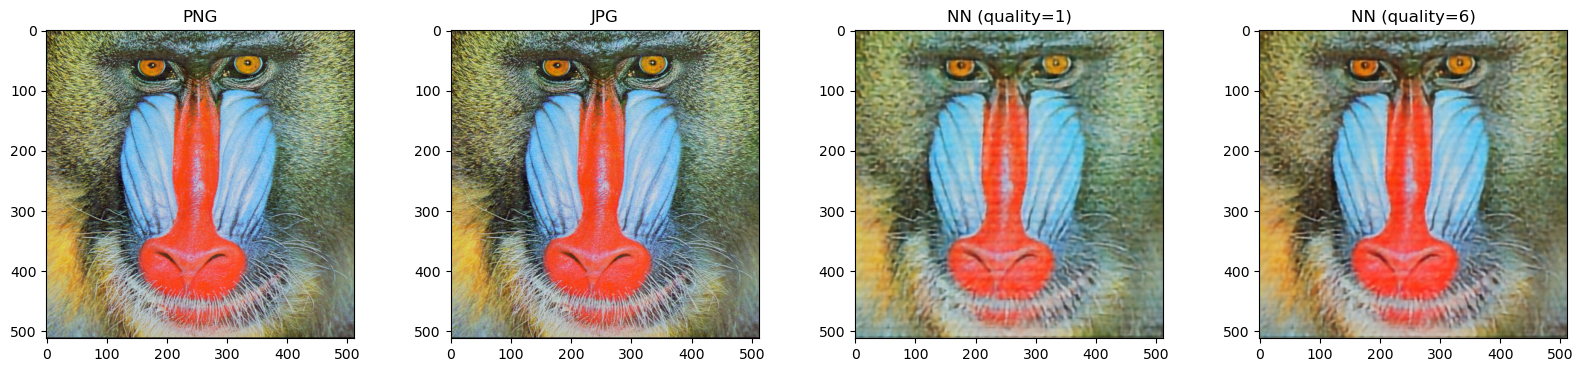

In [12]:
compare('baboon')

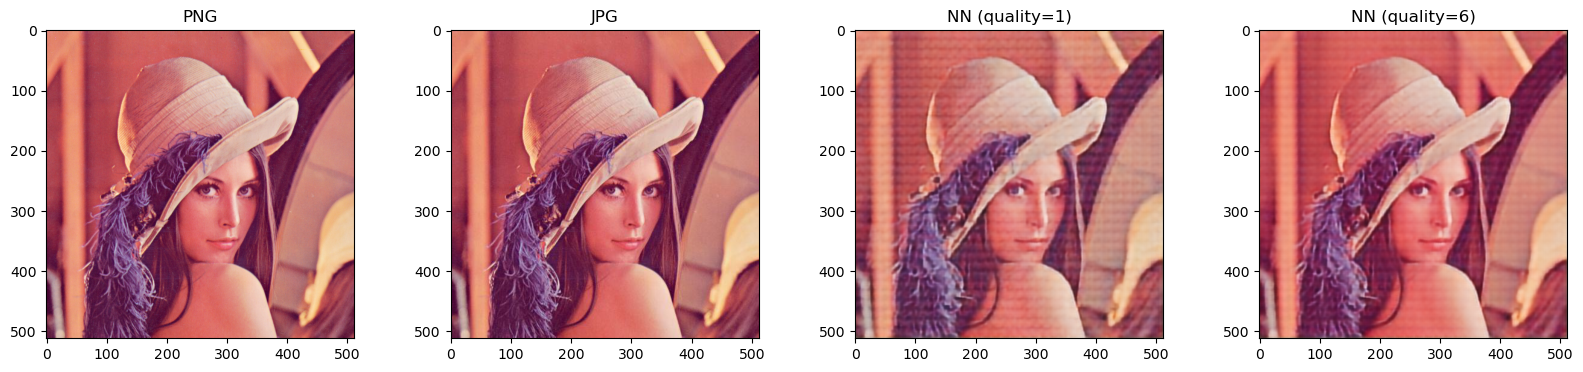

In [13]:
compare('lena')

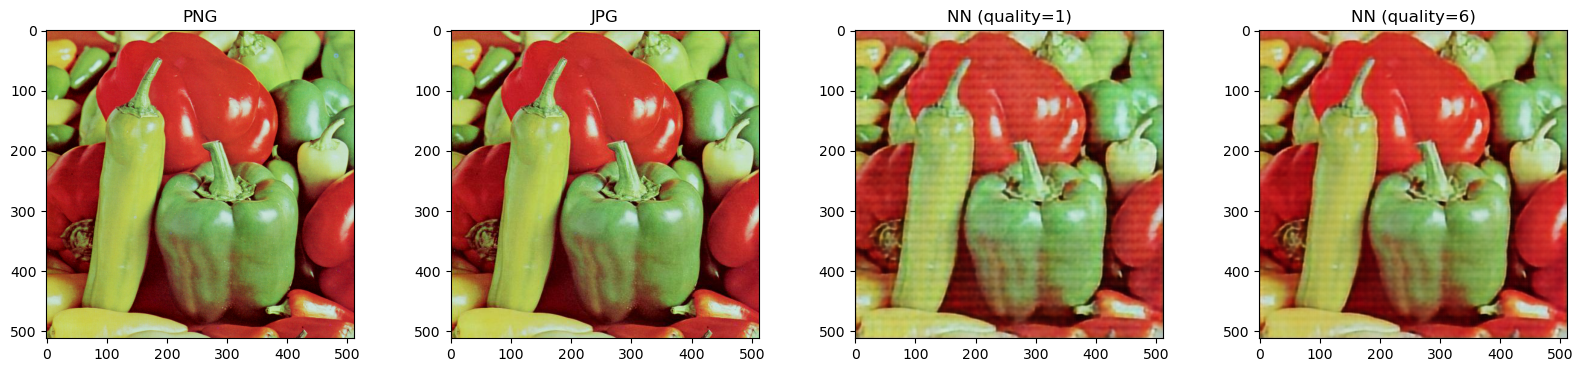

In [14]:
compare('peppers')

In [17]:
def save_to_binary(image_name, quality=1):
    model = ResNet18AE.load_from_checkpoint("neural-codec/3qmpow0d/checkpoints/epoch=0-step=3728.ckpt")

    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    img = skimage.io.imread(f'data/test_images/{image_name}.png')
    img = transform(img)
    img = img.unsqueeze(0)
    model.precision = quality
    model.encode_to_file(img, f'data/test_images/{image_name}.bin')

def load_from_binary(path):
    model = ResNet18AE.load_from_checkpoint("neural-codec/3qmpow0d/checkpoints/epoch=0-step=3728.ckpt")

    model.eval()

    img = None
    for quality in range(1, 7):
        try:
            model.precision = quality
            img = model.decode_from_file(path)
            break
        except AssertionError:
            pass
    img = model.decode_from_file(path)
    img = img[0].permute(1, 2, 0).detach().numpy() * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = np.clip(img, 0, 1)
    return img

BPP/PSNR plot

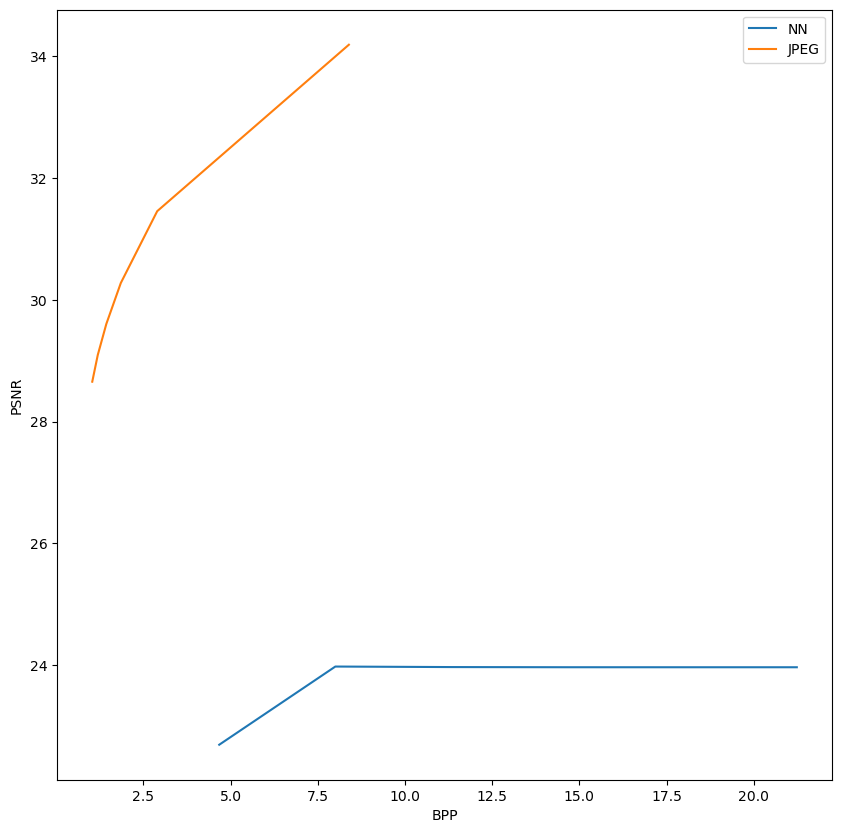

In [24]:
def read_float_image(path):
    img = skimage.io.imread(path)
    img = img.astype(np.float32) / 255.0
    img = np.clip(img, 0, 1)
    return img

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def BPP(path, original_path):
    file_size = os.path.getsize(path)
    image = skimage.io.imread(original_path)
    return file_size * 8 / (image.shape[0] * image.shape[1])


images = ['baboon', 'lena', 'peppers']
nn_qualities = [1, 2, 3, 4, 5, 6]
jpeg_qualities = [50, 60, 70, 80, 90, 100]

nn_avg_psnrs = []
nn_avg_bpps = []
jpeg_avg_psnrs = []
jpeg_avg_bpps = []

for quality in nn_qualities:
    avg_psnr = 0
    avg_bpp = 0
    for image in images:
        save_to_binary(image, quality)
        avg_psnr += PSNR(read_float_image(f'data/test_images/{image}.png'), load_from_binary(f'data/test_images/{image}.bin'))
        avg_bpp += BPP(f'data/test_images/{image}.bin', f'data/test_images/{image}.png')
    nn_avg_psnrs.append(avg_psnr / len(images))
    nn_avg_bpps.append(avg_bpp / len(images))

for quality in jpeg_qualities:
    avg_psnr = 0
    avg_bpp = 0
    for image in images:
        skimage.io.imsave(f'data/test_images/{image}.jpg', skimage.io.imread(f'data/test_images/{image}.png'), quality=quality)
        avg_psnr += PSNR(read_float_image(f'data/test_images/{image}.png'), read_float_image(f'data/test_images/{image}.jpg').astype(np.float32))
        avg_bpp += BPP(f'data/test_images/{image}.jpg', f'data/test_images/{image}.png')
    jpeg_avg_psnrs.append(avg_psnr / len(images))
    jpeg_avg_bpps.append(avg_bpp / len(images))

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(nn_avg_bpps, nn_avg_psnrs, label='NN')
plt.plot(jpeg_avg_bpps, jpeg_avg_psnrs, label='JPEG')
plt.xlabel('BPP')
plt.ylabel('PSNR')
plt.legend()
plt.show()